# Project 2: Ames Property Watch
### Part 3 Model and Kaggle Submission

_Author: Evonne Tham_

---


## Modelling 

### 1. Reimport from File

In [1]:
# Reimport all Libraries 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set_style('darkgrid')

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Read in engineered Data
df_train = pd.read_csv('../datasets/df_train.csv')

#Set id as index 
df_train.set_index('id', inplace=True)

# Check for nulls
(df_train.isnull().sum())[df_train.isnull().sum() > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [6]:
df_train.shape

(2043, 510)

### 2. Create features and target vector

In [10]:
features = [col for col in df_train._get_numeric_data().columns if col != 'saleprice']

X = df_train[features]
y = df_train['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

### 3. Scaling

In [11]:
ss =StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

### 4. Instantiate Models

In [12]:
lr = LinearRegression()
lasso = LassoCV(n_alphas = 200)
ridge = RidgeCV(alphas = np.linspace(.1, 10, 100))

### 5. Cross Validation Across All Models

In [13]:
# Linear Regression
lr_scores = cross_val_score(lr, X_train_ss, y_train, cv=5)
lr_scores.mean()

-7.605787937479433e+21

In [14]:
# Ridge
# Find optimal value for ridge regression alpha
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train_ss, y_train)

print (optimal_ridge.alpha_)

365.4383070957258


In [15]:
# Cross-validate the Ridge regression with the optimal alpha.
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_train_ss, y_train, cv=5)
ridge_scores.mean()

0.9088266009374376

In [16]:
# Lasso
# Find optimal value for lasso regression alpha
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train_ss, y_train)

print (optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

553.6595868259261


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.2s finished


In [17]:
# Lasso
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train_ss, y_train, cv=5)
lasso_scores.mean()

0.9168805802186142

The mean R^2 of Linear Regression model is extremely negative which might be an indication of overfitting where there are a large number of redundant variables that are affecting the coefficients in a certain ways.

However as Ridge is able to manage multicollinearity, the mean R^2 improves drastically

The Lasso here performs only slightly better than the Ridge but that is because it is pretty similar to Ridge. But on top of that it does feature selection which of valuable variables, which also eliminate those that are not useful.

In [18]:
# Refit outside cross_val_score
lasso.fit(X_train_ss, y_train)

# coefficients for variables in the Lasso
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
15,gr_liv_area,15084.350540,15084.350540
36,total_sf,14929.167610,14929.167610
2,overall_qual,12230.708052,12230.708052
7,bsmtfin_sf_1,9729.113113,9729.113113
222,neighborhood_NridgHt,7237.286978,7237.286978
37,housing_age,-6745.457149,6745.457149
228,neighborhood_StoneBr,6497.922976,6497.922976
4,mas_vnr_area,6475.377320,6475.377320
5,exter_qual,5735.150473,5735.150473
50,ms_subclass_120,-4577.667397,4577.667397


In [19]:
print ('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0]))

Percent variables zeroed out: 0.17914831130690162


In [ ]:
lasso_coefs.to_csv('../datasets/lasso_coefs.csv')

## Inferential Visualizations

### 1. Model Fitting and Evaluate

Select to go forward with LassoCV as it seem to be doing the best among all the other models.

In [24]:
lasso.fit(X_train_ss, y_train)
lasso.score(X_train_ss, y_train)

0.9370418554875399

In [25]:
lasso.score(X_test_ss, y_test)

0.8933668978735062

In [26]:
#Predict target values
pred = lasso.predict(X_test_ss)
r2_score(y_test, pred)

0.8933668978735062

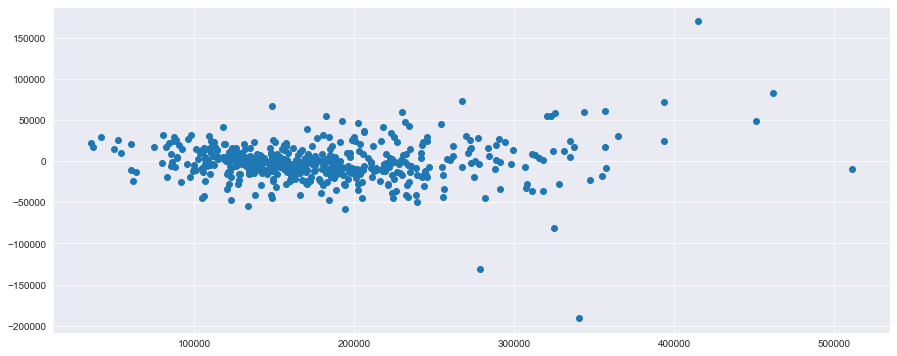

In [27]:
#Plot of the Errors
residuals = y_test - pred

plt.figure(figsize=(15,6))
plt.scatter(pred, residuals);

### 2. Ridge and Lasso Comparison 

In [28]:
ridge.fit(X_train_ss, y_train)
ridge.score(X_train_ss, y_train)

0.9425353839933501

In [29]:
ridge.score(X_test_ss, y_test)

0.8900274542898703

In [31]:
pred_r = ridge.predict(X_test_ss)
r2_score(y_test, pred_r)

0.8900274542898703

Lasso perform slightly better than ridge but not by much

## Test Data

### 1. Create Function to Apply changes to test set

In [32]:
def apply_change_df (data):
    
    ##Rename Columns
    data.columns = [x.replace(' ', '_').lower() for x in data.columns]
    
    ##Drop Columns
    data.drop(columns = ['pid'], axis=1, inplace=True)
    
    ##Fillna for Misc Feature, Alley, Fence and Fireplace Quality
    for i in ['misc_feature','alley','fence']:
        data[i] = data[i].fillna('None')
    
    ##Fillna for lot_frontage
    frontage_mean = data.lot_frontage.mean()
    data['lot_frontage'].fillna(frontage_mean, inplace = True)
    
    ##Fillna for garage variables
    for j in ['garage_finish','garage_yr_blt','garage_type']:
        data[j] = data[j].fillna('None')
    
    
    ##Fillna for bsmt variables
    for i in ['bsmtfin_type_2','bsmtfin_type_1']:
        data[i] = data[i].fillna('None')


    ##Fillna for mas variables    
    data['mas_vnr_type'] = data['mas_vnr_type'].fillna('None')
    data['mas_vnr_area'] = data['mas_vnr_area'].fillna(0)
    
    #Convert ordinal values in variables
    # Variables with Ex, Gd, TA, Fa, & Po
    for x in ['exter_qual','exter_cond','kitchen_qual', 'heating_qc']:
        data[x] = data[x].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
    #Fillna
    for i in ['exter_qual','exter_cond','kitchen_qual', 'heating_qc']:
        data[i] = data[i].fillna('None')
    
    # Variables with Ex, Gd, TA, Fa, Po, & NA
    for y in ['bsmt_qual','bsmt_cond','fireplace_qu', 'garage_qual', 'garage_cond']:
        data[y] = data[y].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1, 'NA':0})
    #Fillna
    for i in ['bsmt_qual','bsmt_cond','fireplace_qu', 'garage_qual', 'garage_cond']:
        data[i] = data[i].fillna('None')
    
    # Exposure 
    data['bsmt_exposure'] = data['bsmt_exposure'].map({'Gd':3,'Av':2,'Mn':1,'No':0,'None':0})
    data['bsmt_exposure'] = data['bsmt_exposure'].fillna('None')
    
    # Pool_qc
    data['pool_qc'] = data['pool_qc'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'NA':0})
    data['pool_qc'] = data['pool_qc'].fillna('None')
    
    # Binarize Central air 
    data['central_air'] = data['central_air'].map(lambda x: '1' if x == 'Y' else '0')
    
    # Binarize Street
    data['street'] = data['street'].map(lambda x: '1' if x == 'Pave' else '2')
    
    # concatenating the square feet of the house
    data['total_sf'] = (data['total_bsmt_sf'] + 
                     data['1st_flr_sf'] + 
                     data['2nd_flr_sf'] + 
                     data['wood_deck_sf'] + 
                     data['open_porch_sf'])
    
    # Calculate total age of house
    data['housing_age'] = data['yr_sold'] - data['year_built']
    
    # Calculate age after Remodeling 
    data['age_after_remod'] = data['yr_sold'] - data['year_remod/add']

    
    #Create seasons variable to group months 
    data['seasons'] = data['mo_sold'].map(lambda x : '4' if x <= 2 else '1' 
                                        if x < 6 else "2" 
                                        if x < 9 else "3" 
                                        if x < 12 else "4")
    
    #Create dummies for categorical variables
    data = pd.get_dummies(data, columns=['ms_subclass','ms_zoning','street','alley', 
                                               'lot_shape', 'land_contour', 'utilities','lot_config',
                                               'land_slope','condition_1','condition_2','bldg_type',
                                               'house_style','roof_style','roof_matl','exterior_1st',
                                               'exterior_2nd','mas_vnr_type','foundation','bsmtfin_type_1',
                                               'bsmtfin_type_2','heating','central_air','electrical',
                                               'functional','garage_type','garage_finish','paved_drive',
                                               'fence', 'misc_feature','sale_type', 'neighborhood',
                                               'year_built', 'year_remod/add', 'garage_yr_blt'], 
                               drop_first=True)

    return data

### 2. load test data

In [33]:
df_test = pd.read_csv("../datasets/test.csv")
df_test.shape

(879, 80)

In [34]:
df_test = apply_change_df(df_test)
df_test.shape

(879, 485)

In [35]:
# #double check against train df
# df_train = pd.read_csv('../datasets/df_train.csv')
df_train.shape

(2043, 510)

The number of columns in the train data does not tally with the column data. Hence further exploration is required. 

### 3. Missing columns in test data

In [36]:
# As only certain columns are used to run the models, 
# we will be looking at the features instead
features = [col for col in df_train._get_numeric_data().columns if col != 'saleprice']

missing_features = [col for col in features if ~np.isin(col,df_test.columns)]
missing_features

['ms_subclass_150',
 'ms_zoning_C (all)',
 'utilities_NoSeWa',
 'condition_2_Feedr',
 'condition_2_RRAe',
 'condition_2_RRAn',
 'condition_2_RRNn',
 'roof_matl_Membran',
 'exterior_1st_CBlock',
 'exterior_1st_ImStucc',
 'exterior_1st_Stone',
 'exterior_2nd_Stone',
 'heating_OthW',
 'heating_Wall',
 'electrical_Mix',
 'functional_Sal',
 'functional_Sev',
 'misc_feature_TenC',
 'neighborhood_GrnHill',
 'neighborhood_Landmrk',
 'year_built_1875',
 'year_built_1879',
 'year_built_1880',
 'year_built_1893',
 'year_built_1895',
 'year_built_1896',
 'year_built_1898',
 'year_built_1901',
 'year_built_1911',
 'year_built_1913',
 'year_built_1929',
 'year_built_1942',
 'garage_yr_blt_1896.0',
 'garage_yr_blt_1900.0',
 'garage_yr_blt_1914.0',
 'garage_yr_blt_1919.0',
 'garage_yr_blt_1929.0',
 'garage_yr_blt_1933.0',
 'garage_yr_blt_1936.0',
 'garage_yr_blt_1942.0',
 'garage_yr_blt_1945.0',
 'garage_yr_blt_2207.0']

In [37]:
df_test = pd.concat([df_test, pd.DataFrame(columns = missing_features)]).fillna(0)
df_test[features].shape

(879, 502)

In [38]:
#Check for null values
(df_test.isnull().sum())[df_test.isnull().sum() > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [39]:
# Check for any duplicates
df_test.duplicated().sum()

0

In [40]:
#features = [col for col in df_test._get_numeric_data().columns if col != 'saleprice']
prediction = df_test[features]
X_testdf_ss = ss.transform(df_test[features])
df_test['saleprice'] = lasso.predict(X_testdf_ss)
df_test['id'] = df_test['id'].astype(int)
kaggle_submission = df_test[['id','saleprice']].set_index('id')

In [41]:
kaggle_submission.to_csv('../datasets/kaggle_submission.csv')